<a href="https://colab.research.google.com/github/pg1992/IA025_2022S1/blob/main/ex03/pedro_moreira/solution_bce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Pedro Guilherme Siqueira Moreira

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [86]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

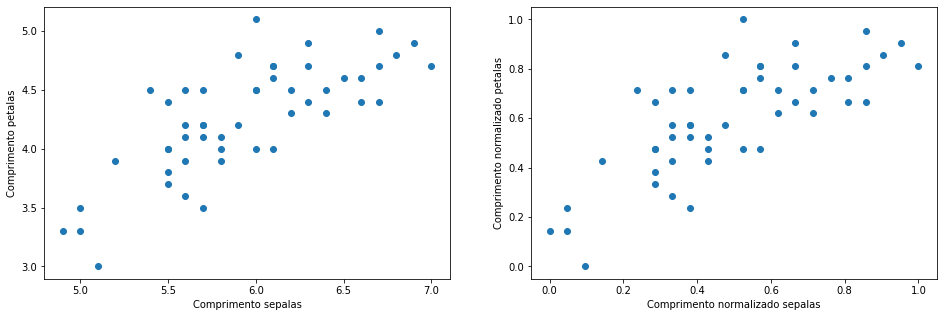

In [87]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [88]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np

random.seed(123)
np.random.seed(123)

In [89]:
class Model():
  def __init__(self, n_in: int, n_out: int):
    # Escreva seu código aqui.
    # Não se esqueça de inicializar os pesos da rede com zeros.
    self.w = np.zeros((n_out, n_in))
      
  def forward(self, x):
    # Escreva seu código aqui.
    y_pred = self.w @ x
    return y_pred

In [90]:
def loss(model, x, y):
  return np.sum((model.forward(x) - y.T)**2) / y.size

In [91]:
def train(model, x, y, learning_rate: float, n_epochs: int):
  """Train a linear model with SGD.

  Returns:
    loss_history: a np.array of shape (n_epochs + 1,)
    w_history: a np.array of shape (n_epochs + 1, 2)
  """
  # Escreva seu código aqui.
  loss_history = np.zeros(n_epochs + 1)
  w_history = np.zeros((n_epochs + 1, 2))

  n = x.size
  x_with_bias = np.vstack((np.ones(n), x.T))

  for i in range(n_epochs):
    y_pred = model.forward(x_with_bias)
    w_history[i] = model.w
    loss_history[i] = loss(model, x_with_bias, y)
    grad = 2 * x_with_bias * (y_pred - y.T) / n
    model.w -= np.sum(learning_rate * grad, axis=1)

  w_history[-1] = model.w
  loss_history[-1] = loss(model, x_with_bias, y)

  return loss_history, w_history

### Testando as funções

In [92]:
model = Model(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train(model=model, x=x, y=y, learning_rate=0.5, n_epochs=20)

In [93]:
# Assert do histórico de losses
target_loss_history = np.array(
    [0.40907029, 0.0559969 , 0.03208511, 0.02972902, 0.02885257,
     0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
     0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
     0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
     0.0228054])

assert np.allclose(loss_history, target_loss_history, atol=1e-6)

In [94]:
# Assert de histórico de pesos da rede
target_w_history = np.array(
    [[0.,         0.        ],
    [0.6,        0.336644  ],
    [0.4339223,  0.27542454],
    [0.4641239,  0.31466085],
    [0.44476733, 0.3271254 ],
    [0.43861815, 0.3453676 ],
    [0.42961866, 0.3611236 ],
    [0.4218457,  0.37655178],
    [0.41423446, 0.3911463 ],
    [0.40703452, 0.4050796 ],
    [0.40016073, 0.41834888],
    [0.39361456, 0.43099412],
    [0.38737625, 0.44304258],
    [0.38143232, 0.4545229 ],
    [0.3757687,  0.4654618 ],
    [0.37037218, 0.4758848 ],
    [0.36523017, 0.48581624],
    [0.36033067, 0.49527928],
    [0.35566223, 0.50429606],
    [0.35121396, 0.5128876 ],
    [0.34697545, 0.52107394]])

assert np.allclose(w_history, target_w_history, atol=1e-6)

# Função de cálculo do grid de custos

In [95]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array of shape (w_0_grid.shape[0], w_1_grid.shape[0]). 
    """
    n = x.size
    w0, w1 = np.meshgrid(w_0_grid, w_1_grid)
    w0 = w0[:,:,np.newaxis]
    w1 = w1[:,:,np.newaxis]
    x = x.reshape((1,-1))[np.newaxis,:]
    y = y.reshape((1,-1))[np.newaxis,:]
    y_pred = w0 + w1 * x
    loss_grid = np.sum((y - y_pred)**2,axis=2) / n
    return loss_grid

In [96]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

### Testando a função

In [97]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [98]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6)

## Funcão de Plot

In [99]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

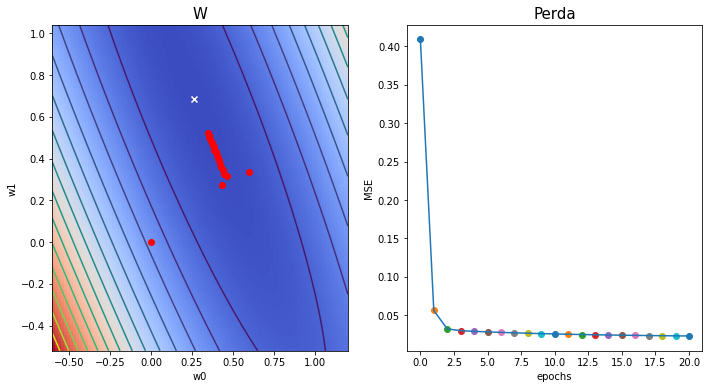

In [100]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass

# Solução com entropia cruzada como custo

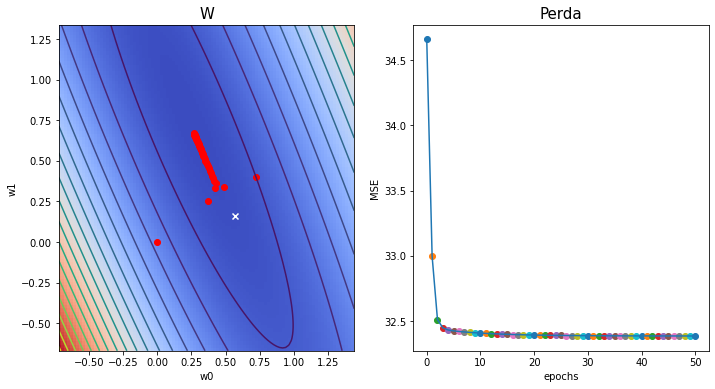

In [104]:
class ModelSigmoid():
  def __init__(self, n_in: int, n_out: int):
    self.w = np.zeros((n_out, n_in))
      
  def forward(self, x):
    y_pred = 1 / (1 + np.exp(-self.w @ x))
    return y_pred

def BCE(y,y_hat):
    return -((y * np.log(y_hat))+((1 - y) * np.log(1 - y_hat)))

def loss_bce(y, y_hat):
  return np.sum(BCE(y, y_hat))
    
def train_bce(model, x, y, learning_rate: float, n_epochs: int):
  """Train a linear model with SGD.

  Returns:
    loss_history: a np.array of shape (n_epochs + 1,)
    w_history: a np.array of shape (n_epochs + 1, 2)
  """
  # Escreva seu código aqui.
  loss_history = np.zeros(n_epochs + 1)
  w_history = np.zeros((n_epochs + 1, 2))

  n = x.size
  x_with_bias = np.vstack((np.ones(n), x.T))

  for i in range(n_epochs):
    y_pred = model.forward(x_with_bias)
    w_history[i] = model.w
    loss_history[i] = loss_bce(y, y_pred)
    grad = (y_pred - y) * x_with_bias
    model.w -= np.sum(learning_rate * grad, axis=1)

  w_history[-1] = model.w
  loss_history[-1] = loss_bce(y, y_pred)

  return loss_history, w_history

y_sig = 1 / (1 + np.exp(-y))
model = ModelSigmoid(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train_bce(model=model, x=x, y=y_sig.T, learning_rate=0.1, n_epochs=50)

def compute_loss_bce_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array of shape (w_0_grid.shape[0], w_1_grid.shape[0]). 
    """
    n = x.size
    w0, w1 = np.meshgrid(w_0_grid, w_1_grid)
    w0 = w0[:,:,np.newaxis]
    w1 = w1[:,:,np.newaxis]
    x = x.reshape((1,-1))[np.newaxis,:]
    y = y.reshape((1,-1))[np.newaxis,:]
    y_pred = 1 / (1 + np.exp(-(w0 + w1 * x)))
    loss_grid = np.sum(BCE(y, y_pred),axis=2)
    return loss_grid

wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_bce_grid(x, y_sig.T, w_0_grid, w_1_grid)

def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)

%matplotlib inline
try:
    show_plots(x, y_sig, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass